<a href="https://colab.research.google.com/github/eanasir/SSN-MEiL/blob/main/ssn_meil_lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy as np


class Loss_fcn:
  def __init__(self):
    self.functions = {
      'mse': self.mse,
      'bc_entropy': self.bc_entropy
      }
  def mse(self, expected, outputs, derivative=False):

    expected = np.asarray(expected, dtype=float)
    outputs = np.asarray(outputs, dtype=float)

    if not derivative:
      return 0.5 * (expected - outputs) ** 2
    else:
      return (outputs - expected)

  def bc_entropy(self,expected,outputs,derivative = False):

    expected = np.asarray(expected, dtype=float)
    outputs = np.asarray(outputs, dtype=float)

    if not derivative:
      return expected * np.log(outputs) + (1- expected) * np.log(1 - outputs)
    else:
      return (1 - expected) / (1- outputs) - (expected / outputs)

  def output(self,name, expected, outputs, derivative=False):
        if name not in self.functions:
            sys.exit(f"Error: Loss function '{name}' not found.")
        return self.functions[name](expected,outputs, derivative=derivative)

In [ ]:
import sys
import numpy as np

class Activation_fcn:
    def __init__(self):
        self.functions = {
            'linear':   self.linear,
            'sigmoid':  self.sigmoid,
            'logistic': self.logistic,
            'tanh':     self.tanh,
            'relu':     self.relu
        }

    def output(self, z, name, derivative=False):
        if name not in self.functions:
            sys.exit(f"Error: Activation function '{name}' not found.")
        return self.functions[name](z, derivative=derivative)

    def linear(self, z, derivative=False):
        if derivative:
            return np.ones_like(z)
        return z

    def sigmoid(self, z, derivative=False):
        s = 1.0 / (1.0 + np.exp(-z))
        if derivative:
            return s * (1.0 - s)
        return s

    def tanh(self, z, derivative=False):
        t = np.tanh(z)
        if derivative:
            return 1.0 - t**2
        return t

    def relu(self, z, derivative=False):
        if derivative:
            return (z >= 0).astype(z.dtype if np.issubdtype(z.dtype, np.number) else float)
        return np.maximum(0, z)

    def logistic(self, z, derivative=False):

        l = 1.0 / (1.0 + np.exp(-z - 0.5))
        if derivative:
            return l * (1.0 - l)
        return l


In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class Neural_network:
  def __init__(self, structure=None, init_weight='rand'):
    self.af = Activation_fcn()
    if structure:
        self.network = self.create_network(structure, init_weight=init_weight)
    self.train_loss_history = []
    self.validation_loss_history = []
    self.current_patience = None
    self.best_validation_loss = None
    self.best_model = None

  def create_network(self, structure, init_weight='rand'):
      self.nnetwork = [structure[0]]
      for i in range(1, len(structure)):
          new_layer = {
              'weights': None,
              'activation_function': structure[i]['activation_function'],
              'activation_potential': None,
              'gradient_squared_accumulation': None,
              'delta': None,
              'output': None
          }
          out_units = structure[i]['units']
          in_units  = structure[i-1]['units']
          match init_weight:
              case "rand":
                  new_layer["weights"] = np.random.randn(out_units, in_units)
              case "zero":
                  new_layer["weights"] = np.zeros((out_units, in_units))
              case "ones":
                  new_layer["weights"] = np.ones((out_units, in_units))
              case _:
                  print("init weight not recognized")
          new_layer["gradient_squared_accumulation"] = np.zeros((out_units, in_units))
          self.nnetwork.append(new_layer)
      return self.nnetwork

  def forward_propagate(self, nnetwork, inputs):
      A = np.asarray(inputs).reshape(-1, 1)
      for i in range(1, len(nnetwork)):
          W = nnetwork[i]["weights"]
          Z = W @ A
          A = self.af.output(Z, nnetwork[i]['activation_function'])
          nnetwork[i]['activation_potential'] = Z
          nnetwork[i]['output'] = A
      return A

  def predict(self, nnetwork, inputs):
      X = np.asarray(inputs)
      if X.ndim == 1:
          return self.forward_propagate(nnetwork, X).ravel()
      elif X.ndim == 2:
          outs = []
          for row in X:
              y = self.forward_propagate(nnetwork, row).ravel()
              outs.append(y)
          return np.vstack(outs)

  def train(self, nnetwork, x_data, y_data, test_size=0.2, l_rate=0.01, n_epoch=100, loss_function='mse', epsilon=1e-6, patience=10, optimizer='SGD'):
      x_train, x_validation, y_train, y_validation = train_test_split(np.asarray(x_data), np.asarray(y_data), test_size=float(test_size), shuffle=True)
      number_of_training_samples = len(x_train)
      number_of_validation_samples = len(x_validation)
      loss_calculator = Loss_fcn()
      self.train_loss_history = []
      self.validation_loss_history = []
      self.current_patience = patience
      self.best_validation_loss = np.inf
      self.best_model = copy.deepcopy(nnetwork)
      previous_training_loss = None
      for epoch_index in range(n_epoch):
          training_loss_sum = 0.0
          for iteration_index, (input_sample, expected_sample) in enumerate(zip(x_train, y_train)):
              self.forward_propagate(nnetwork, input_sample)
              loss_value = np.sum(loss_calculator.output(loss_function, expected_sample, nnetwork[-1]['output'], derivative=False))
              training_loss_sum += loss_value
              self.backward_propagate(loss_function, nnetwork, expected_sample)
              self.update_weights(nnetwork, input_sample, l_rate, optimizer, epsilon)
          average_training_loss = training_loss_sum / number_of_training_samples if number_of_training_samples > 0 else 0.0
          validation_loss_sum = 0.0
          for validation_input, validation_expected in zip(x_validation, y_validation):
              self.forward_propagate(nnetwork, validation_input)
              validation_loss_sample = np.sum(loss_calculator.output(loss_function, validation_expected, nnetwork[-1]['output'], derivative=False))
              validation_loss_sum += validation_loss_sample
          average_validation_loss = validation_loss_sum / number_of_validation_samples if number_of_validation_samples > 0 else 0.0
          self.train_loss_history.append(average_training_loss)
          self.validation_loss_history.append(average_validation_loss)
          should_stop = self.early_stop(nnetwork, average_training_loss, previous_training_loss, average_validation_loss, epsilon, patience)
          previous_training_loss = average_training_loss
          if should_stop:
              self.plot_loss_history()
              return self.best_model
      self.plot_loss_history()
      return self.best_model

  def early_stop(self, network, current_training_loss, previous_training_loss, current_validation_loss, epsilon, patience):
      if previous_training_loss is not None:
          if abs(current_training_loss - previous_training_loss) < epsilon:
              print("Early stopping: training loss change below epsilon")
              return True
      if current_validation_loss < self.best_validation_loss:
          self.best_validation_loss = current_validation_loss
          self.best_model = copy.deepcopy(network)
          self.current_patience = patience
          return False
      else:
          self.current_patience -= 1
          if self.current_patience <= 0:
              print("Early stopping: no validation loss improvement within patience")
              return True
          return False

  def backward_propagate(self, loss_function, nnetwork, expected):
      N = len(nnetwork) - 1
      loss = Loss_fcn()
      expected = np.asarray(expected).reshape(-1, 1)
      for i in range(N, 0, -1):
          if i == N:
              errors = loss.output(loss_function, expected, nnetwork[i]['output'],  derivative=True)
          else:
              errors = nnetwork[i+1]['weights'].T @ nnetwork[i+1]['delta']
          nnetwork[i]['delta'] = np.multiply(errors, self.af.output(nnetwork[i]['activation_potential'], nnetwork[i]['activation_function'], derivative=True))

  def update_weights(self, nnetwork, inputs, l_rate, optimizer, epsilon):
      inp = inputs
      for i in range(1, len(nnetwork)):
          A_prev = np.asarray(inp).reshape(-1, 1)
          delta = nnetwork[i]['delta']
          gradient = delta @ A_prev.T
          if optimizer is not None and str(optimizer).lower() == 'adagrad':
              nnetwork[i]['gradient_squared_accumulation'] += gradient * gradient
              adjusted_learning_rate = l_rate / (np.sqrt(nnetwork[i]['gradient_squared_accumulation']) + epsilon)
              nnetwork[i]['weights'] -= adjusted_learning_rate * gradient
          else:
              nnetwork[i]['weights'] -= l_rate * gradient
          inp = nnetwork[i]['output']

  def plot_loss_history(self):
      epochs = list(range(1, len(self.train_loss_history) + 1))
      plt.figure()
      plt.plot(epochs, self.train_loss_history, label='training loss')
      plt.plot(epochs, self.validation_loss_history, label='validation loss')
      plt.xlabel('epoch')
      plt.ylabel('average loss')
      plt.title('Loss history')
      plt.legend()
      plt.show()


Early stopping: training loss change below epsilon


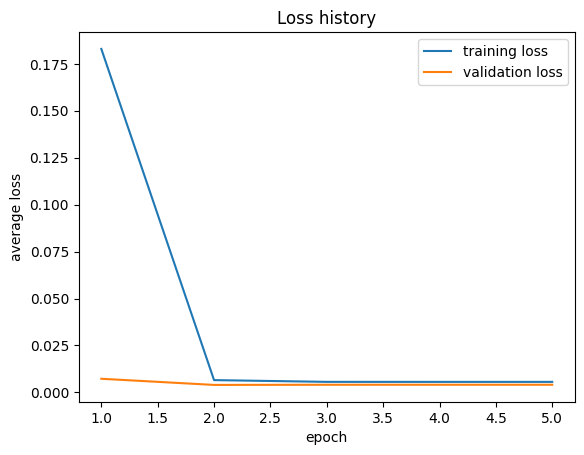

final average training loss: 0.005597586454456795
final average validation loss: 0.004068186562184706


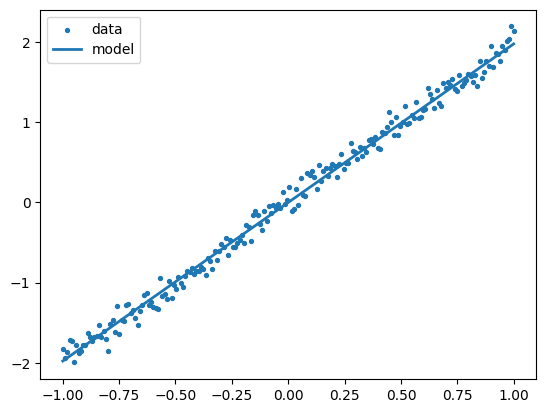

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

x_values = np.linspace(-1, 1, 200).reshape(-1, 1)
y_values = (2.0 * x_values) + (0.1 * np.random.randn(*x_values.shape))

network_structure = [
    {'units': 1},
    {'units': 1, 'activation_function': 'linear'}
]

neural_network_instance = Neural_network(structure=network_structure, init_weight='rand')

trained_network = neural_network_instance.train(
    neural_network_instance.network,
    x_values,
    y_values,
    test_size=0.2,
    l_rate=0.05,
    n_epoch=100,
    loss_function='mse'
)

print("final average training loss:", neural_network_instance.train_loss_history[-1])
print("final average validation loss:", neural_network_instance.validation_loss_history[-1])
plt.figure()
plt.scatter(x_values, y_values, s=8, label='data')
predictions = neural_network_instance.predict(trained_network, x_values).ravel()
plt.plot(x_values.ravel(), predictions, label='model', linewidth=2)
plt.legend()
plt.show()


In [ ]:

def generate_regression_data(n=30):
    X = np.linspace(-5, 5, n).reshape(-1, 1)
    y = np.sin(2 * X) + np.cos(X) + 5
    data_noise = np.random.normal(0, 0.2, n).reshape(-1, 1)
    Y = y + data_noise
    return X.reshape(-1, 1), Y.reshape(-1, 1)

Early stopping: no validation loss improvement within patience


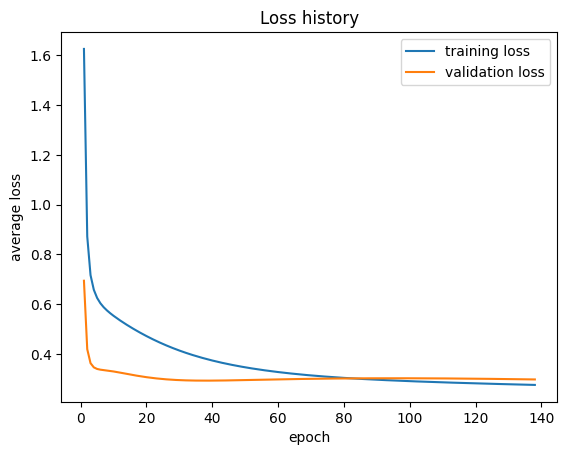

trained best validation loss: 0.2922577282274734
epochs run: 138
final training loss: 0.27503580350219664
final validation loss: 0.2970322831473252


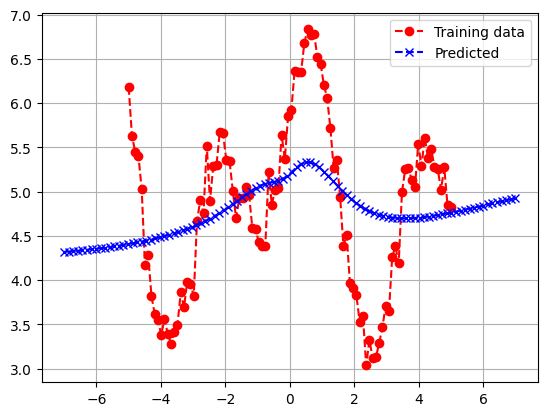

In [ ]:
np.random.seed(0)
'''
X = np.linspace(-1, 1, 200).reshape(-1,1)
true_weights = 2.0
y = (true_weights * X).reshape(-1,1) + np.random.normal(scale=0.1, size=(200,1))
'''


X, Y = generate_regression_data(100)

structure = [
        {'type': 'input', 'units': 1},
        {'type': 'dense', 'units': 32, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 32, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 1, 'activation_function': 'linear'},
    ]
model = Neural_network(structure=structure, init_weight='rand')

trained_model = model.train(
  model.network,
  X,
  Y,
  test_size=0.2,
  l_rate=0.001,
  n_epoch=5000,
  loss_function='mse',
  epsilon=1e-9,
  patience=100
)

print('trained best validation loss:', model.best_validation_loss)
print('epochs run:', len(model.train_loss_history))
print('final training loss:', model.train_loss_history[-1] if model.train_loss_history else None)
print('final validation loss:', model.validation_loss_history[-1] if model.validation_loss_history else None)

plt.plot(X, Y, 'r--o', label='Training data')
X_test = np.linspace(-7, 7, 100).reshape(-1, 1)
predicted_test = model.predict(trained_model, X_test)
plt.plot(X_test, predicted_test, 'b--x', label='Predicted')
plt.legend()
plt.grid()
plt.show()

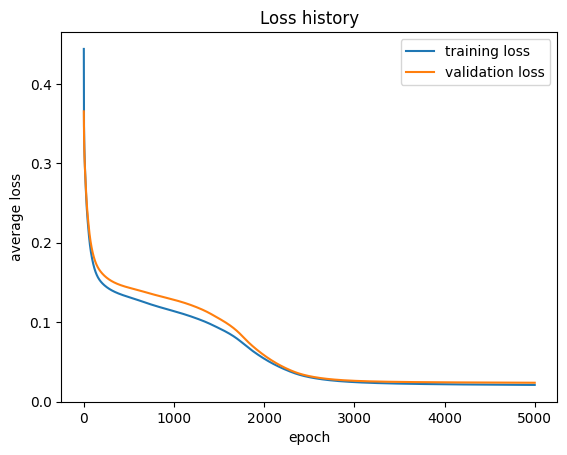

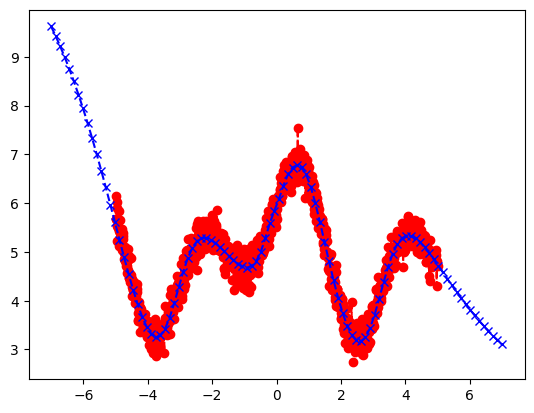

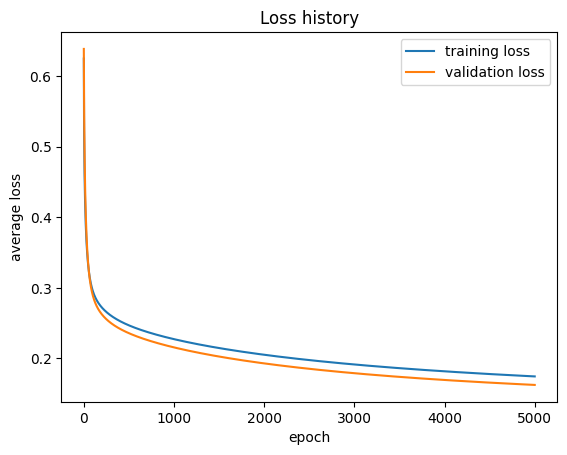

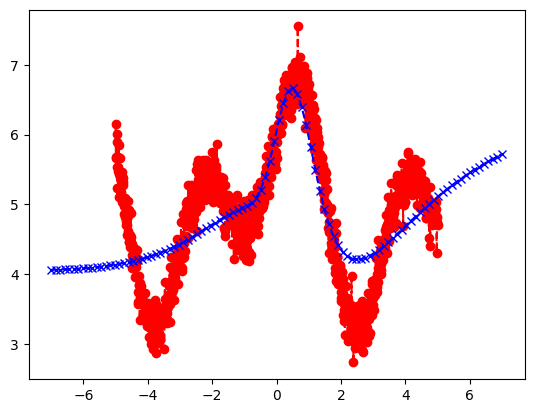

In [ ]:
np.random.seed(1)

'''
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])
'''

X, Y = generate_regression_data(1000)

structure = [
        {'type': 'input', 'units': 1},
        {'type': 'dense', 'units': 32, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 32, 'activation_function': 'sigmoid'},
        {'type': 'dense', 'units': 1, 'activation_function': 'linear'},
    ]

network_sgd = Neural_network(structure=structure, init_weight='rand')
best_model_sgd = network_sgd.train(
    network_sgd.network,
    X,
    Y,
    test_size=0.2,
    l_rate=0.001,
    n_epoch=5000,
    loss_function='mse',
    epsilon=1e-8,
    patience=100,
    optimizer='SGD'
    )


plt.plot(X, Y, 'r--o', label='Training data')
X_test = np.linspace(-7, 7, 100).reshape(-1, 1)
plt.plot(X_test, network_sgd.predict(best_model_sgd, X_test), 'b--x', label='Predicted')

network_adagrad = Neural_network(structure=structure, init_weight='rand')
best_model_adagrad = network_adagrad.train(
    network_adagrad.network,
    X,
    Y,
    test_size=0.2,
    l_rate=0.001,
    n_epoch=5000,
    loss_function='mse',
    epsilon=1e-8,
    patience=100,
    optimizer='adagrad'
    )

plt.plot(X, Y, 'r--o', label='Training data')
plt.plot(X_test, network_sgd.predict(best_model_adagrad, X_test), 'b--x', label='Predicted')